In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Elsevier XML Caption Extractor
- Extract Figure/Table captions from multiple XML files
- Output as CSV
- Uses lxml + XPath(local-name())
- Includes logging + tqdm progress

Usage:
python extract_captions.py --xml_dir ./xmls --output captions.csv
"""

import os
import argparse
import logging
from tqdm import tqdm
import csv
from lxml import etree


# -----------------------------------------------------
# Logging
# -----------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)


# -----------------------------------------------------
# Clean text helper
# -----------------------------------------------------
def clean_text(s: str) -> str:
    if not s:
        return ""
    s = s.replace("\n", " ").replace("\t", " ")
    s = " ".join(s.split())
    return s.strip()


# -----------------------------------------------------
# Extract captions from one XML file
# -----------------------------------------------------
def extract_captions_from_file(xml_path: str):
    try:
        tree = etree.parse(xml_path)
        root = tree.getroot()
    except Exception as e:
        logging.error(f"Failed to parse {xml_path}: {e}")
        return []

    records = []

    # ------------ Figures ------------
    fig_nodes = root.xpath("//*[local-name()='figure']")
    for node in fig_nodes:
        label = " ".join(node.xpath(".//*[local-name()='label']//text()"))
        cap = " ".join(node.xpath(".//*[local-name()='caption']//text()"))

        label = clean_text(label)
        cap = clean_text(cap)

        if cap:
            records.append({
                "file": os.path.basename(xml_path),
                "type": "figure",
                "label": label,
                "caption": cap,
            })

    # ------------ Tables ------------
    tbl_nodes = root.xpath("//*[local-name()='table']")
    for node in tbl_nodes:
        label = " ".join(node.xpath(".//*[local-name()='label']//text()"))
        cap = " ".join(node.xpath(".//*[local-name()='caption']//text()"))

        label = clean_text(label)
        cap = clean_text(cap)

        if cap:
            records.append({
                "file": os.path.basename(xml_path),
                "type": "table",
                "label": label,
                "caption": cap,
            })

    return records


# -----------------------------------------------------
# Process all files in a directory
# -----------------------------------------------------
def extract_from_dir(xml_dir: str):
    results = []

    # collect files
    files = []
    for root, dirs, fs in os.walk(xml_dir):
        for f in fs:
            if f.lower().endswith(".xml"):
                files.append(os.path.join(root, f))

    logging.info(f"Found {len(files)} XML files.")

    for fpath in tqdm(files, desc="Extracting captions"):
        recs = extract_captions_from_file(fpath)
        results.extend(recs)

    return results


# -----------------------------------------------------
# Save to CSV
# -----------------------------------------------------
def save_csv(rows, out_path: str):
    fieldnames = ["file", "type", "label", "caption"]

    with open(out_path, "w", encoding="utf-8-sig", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for r in rows:
            writer.writerow(r)

    logging.info(f"Saved {len(rows)} rows to {out_path}")


# -----------------------------------------------------
# CLI
# -----------------------------------------------------

rows = extract_from_dir("./xmls/")
save_csv(rows, "captions.csv")

2025-12-04 15:48:59,716 | INFO | Found 2826 XML files.
Extracting captions: 100%|██████████| 2826/2826 [01:39<00:00, 28.50it/s]
2025-12-04 15:50:39,255 | INFO | Saved 38969 rows to captions.csv


In [11]:
pd.DataFrame(rows)

,file,type,label,caption
0,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 1,(a) Experimental setup for the synthesis of se...
1,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 2,Typical temperature profile accompanying the g...
2,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 3,Absorption spectra of CdSe nanocrystals dissol...
3,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 4,Photoluminescence spectra of the same CdSe sam...
4,S0001-8686(00)00040-3__FULL.xml,figure,Fig. 5,Time-dependent spectral characteristics of exp...
...,...,...,...,...
38964,S0165-2370(22)00100-0__FULL.xml,table,Table 5,Kinetic parameters for PP.
38965,S0165-2370(22)00100-0__FULL.xml,table,Table 6,Comparison of the activation energies obtained...
38966,S0165-2370(22)00100-0__FULL.xml,table,Table 7,Rate constants (min −1 ) for polyolefins at 45...
38967,S0165-2370(22)00100-0__FULL.xml,table,Table 8,Comparison between the reported rate constants...


In [7]:
import pandas as pd 

CAPTIONS = pd.read_csv("./captions.csv")
SEARCJH_9706 = pd.read_csv("./9706_searched.csv")
SEARCJH_9706
CAPTIONS["pii"] = CAPTIONS["file"].apply(lambda x: x.split("_")[0])
# CAPTIONS에서 caption이 존재하는 PII 집합
pii_with_caption = set(CAPTIONS['pii'].unique())

# SEARCHJH 전체 PII 집합
pii_all = set(SEARCJH_9706['pii'].unique())

# caption이 하나도 없는 PII
pii_without_caption = pii_all - pii_with_caption

len(pii_without_caption)



7263

In [ ]:
len(pii_with_caption)

2444

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
from lxml import etree
import logging
from tqdm import tqdm
import pandas as pd

XML_DIR = "./xmls"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)

# -----------------------------------------------------
# helper: clean text
# -----------------------------------------------------
def clean(s):
    if not s:
        return None
    s = s.replace("\n", " ").replace("\t", " ")
    s = " ".join(s.split())
    return s.strip()


# -----------------------------------------------------
# parse single xml
# -----------------------------------------------------
def parse_xml(path):
    try:
        tree = etree.parse(path)
        root = tree.getroot()
    except Exception as e:
        logging.error(f"parse error: {path} | {e}")
        return {
            "file": os.path.basename(path),
            "has_rawtext": False,
            "date_search_begin": None,
            "year_nav": None
        }

    # --------------------------
    # rawtext check
    # --------------------------
    rawtext_nodes = root.xpath("//*[local-name()='rawtext']")
    has_rawtext = len(rawtext_nodes) > 0

    # --------------------------
    # date-search-begin
    # --------------------------
    date_nodes = root.xpath("//*[local-name()='date-search-begin']//text()")
    date_val = clean(date_nodes[0]) if date_nodes else None

    # --------------------------
    # year-nav
    # --------------------------
    year_nodes = root.xpath("//*[local-name()='year-nav']//text()")
    year_val = clean(year_nodes[0]) if year_nodes else None

    return {
        "file": os.path.basename(path),
        "has_rawtext": has_rawtext,
        "date_search_begin": date_val,
        "year_nav": year_val
    }


# -----------------------------------------------------
# run over directory
# -----------------------------------------------------
def run(xml_dir):
    xml_files = [
        os.path.join(xml_dir, f)
        for f in os.listdir(xml_dir)
        if f.lower().endswith(".xml")
    ]

    logging.info(f"총 XML 파일: {len(xml_files)}")

    records = []

    for path in tqdm(xml_files, desc="Parsing XML"):
        rec = parse_xml(path)
        records.append(rec)

    return records


# -----------------------------------------------------
# main
# -----------------------------------------------------
records = run(XML_DIR)

# pandas dataframe
df = pd.DataFrame(records)

# save
df.to_csv("xml_metadata.csv", index=False, encoding="utf-8-sig")

# summary log
logging.info("=== Summary ===")
logging.info(f"Total files: {len(df)}")
logging.info(f"Has rawtext: {df['has_rawtext'].sum()}")
logging.info(f"No rawtext: {(~df['has_rawtext']).sum()}")

logging.info(f"Rows saved: xml_metadata.csv")


2025-12-04 16:07:09,334 | INFO | 총 XML 파일: 6118
Parsing XML:   0%|          | 0/6118 [00:00<?, ?it/s]

Parsing XML: 100%|██████████| 6118/6118 [04:13<00:00, 24.15it/s]
2025-12-04 16:11:22,732 | INFO | === Summary ===
2025-12-04 16:11:22,733 | INFO | Total files: 6118
2025-12-04 16:11:22,734 | INFO | Has rawtext: 393
2025-12-04 16:11:22,735 | INFO | No rawtext: 5725
2025-12-04 16:11:22,735 | INFO | Rows saved: xml_metadata.csv


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
from lxml import etree
import logging
from tqdm import tqdm
import pandas as pd
from multiprocessing import Pool, cpu_count


XML_DIR = "./xmls"  # XML 폴더 경로
N_WORKERS = max(1, cpu_count() - 1)  # 추천: 전체 CPU - 1

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)


# -----------------------------------------------------
# helper: clean text
# -----------------------------------------------------
def clean(s):
    if not s:
        return None
    s = s.replace("\n", " ").replace("\t", " ")
    s = " ".join(s.split())
    return s.strip()


# -----------------------------------------------------
# parse single xml (must be top-level for multiprocessing)
# -----------------------------------------------------
def parse_xml(path):
    fname = os.path.basename(path)

    try:
        tree = etree.parse(path)
        root = tree.getroot()
    except Exception:
        # 파싱 실패 시 기본값 반환
        return {
            "file": fname,
            "has_rawtext": False,
            "date_search_begin": None,
            "year_nav": None
        }

    # --------------------------
    # rawtext 존재 검출
    # --------------------------
    rawtext_nodes = root.xpath("//*[local-name()='rawtext']")
    has_rawtext = len(rawtext_nodes) > 0

    # --------------------------
    # date-search-begin
    # --------------------------
    date_nodes = root.xpath("//*[local-name()='date-search-begin']//text()")
    date_val = clean(date_nodes[0]) if date_nodes else None

    # --------------------------
    # year-nav
    # --------------------------
    year_nodes = root.xpath("//*[local-name()='year-nav']//text()")
    year_val = clean(year_nodes[0]) if year_nodes else None

    return {
        "file": fname,
        "has_rawtext": has_rawtext,
        "date_search_begin": date_val,
        "year_nav": year_val
    }


# -----------------------------------------------------
# parallel run
# -----------------------------------------------------
def run_parallel(xml_dir):
    # 대상 XML 파일 리스트 수집
    xml_files = [
        os.path.join(xml_dir, f)
        for f in os.listdir(xml_dir)
        if f.lower().endswith(".xml")
    ]

    logging.info(f"총 XML 파일: {len(xml_files)}")
    logging.info(f"사용 CPU: {N_WORKERS}")

    records = []

    # 병렬 실행
    with Pool(N_WORKERS) as pool:
        for rec in tqdm(pool.imap_unordered(parse_xml, xml_files), total=len(xml_files)):
            records.append(rec)

    return records


# -----------------------------------------------------
# main
# -----------------------------------------------------

records = run_parallel(XML_DIR)

# pandas dataframe
df = pd.DataFrame(records)

# save
out_csv = "xml_metadata.csv"
df.to_csv(out_csv, index=False, encoding="utf-8-sig")

# summary
total = len(df)
with_raw = df["has_rawtext"].sum()
without_raw = total - with_raw

logging.info("=== Summary ===")
logging.info(f"Total files: {total}")
logging.info(f"Has rawtext: {with_raw}")
logging.info(f"No rawtext: {without_raw}")
logging.info(f"Rows saved: {out_csv}")


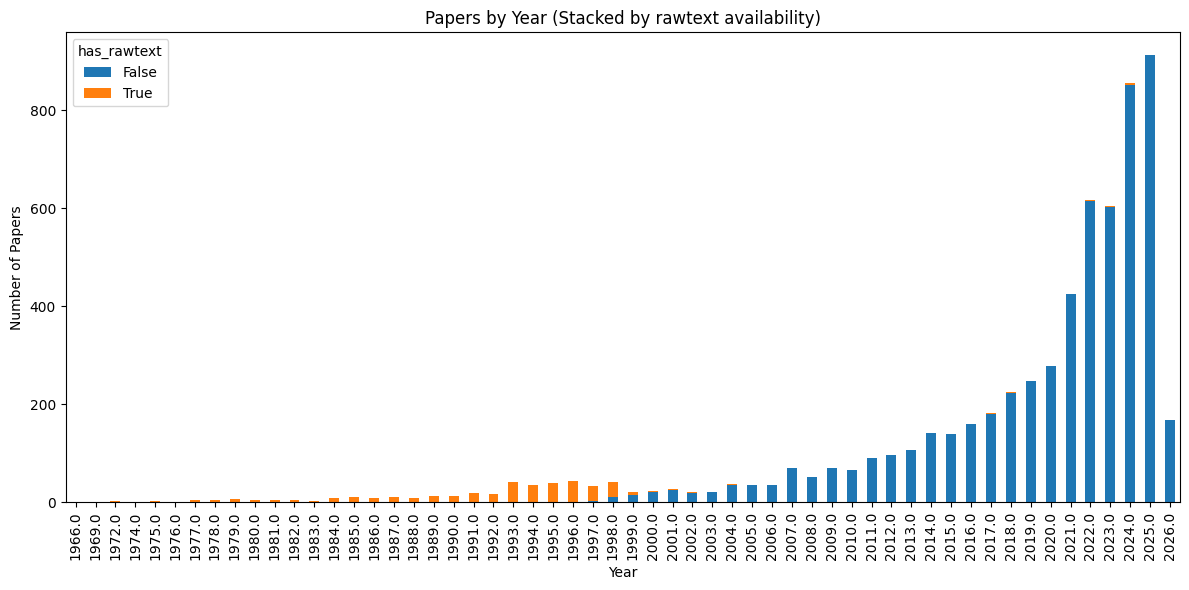

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("xml_metadata.csv")

# year_nav → 정수로 변환
df['year'] = pd.to_numeric(df['year_nav'], errors='coerce').dropna().astype(int)

pivot = df.pivot_table(
    index='year',
    columns='has_rawtext',
    aggfunc='size',
    fill_value=0
)

pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("Papers by Year (Stacked by rawtext availability)")
plt.tight_layout()
plt.show()



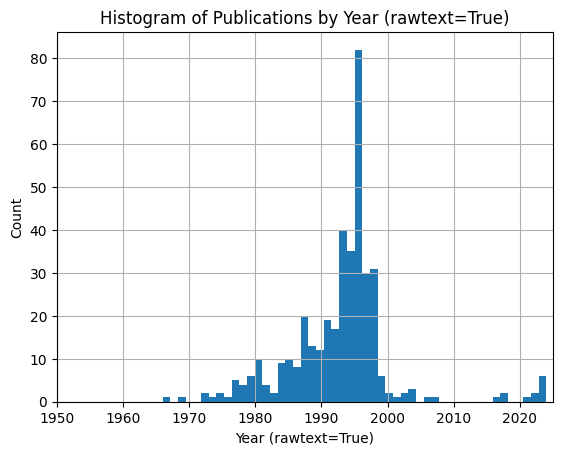

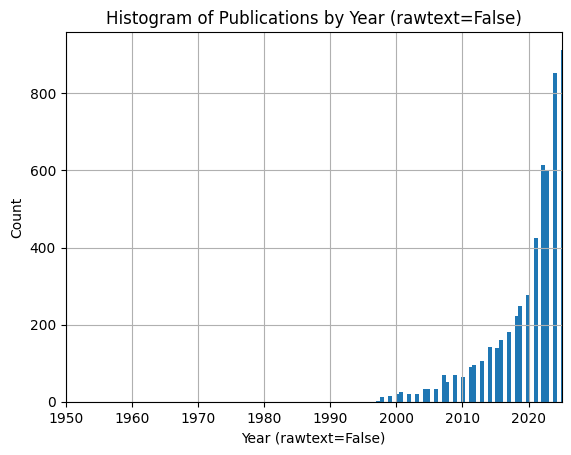

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("xml_metadata.csv")

df['year'] = pd.to_numeric(df['year_nav'], errors='coerce')

# rawtext True
df_true = df[df['has_rawtext'] == True]
plt.figure()
df_true['year'].dropna().hist(bins=50)
plt.xlabel("Year (rawtext=True)")
plt.ylabel("Count")
plt.title("Histogram of Publications by Year (rawtext=True)")
plt.xlim(1950, 2025)
plt.show()

# rawtext False
df_false = df[df['has_rawtext'] == False]
plt.figure()
df_false['year'].dropna().hist(bins=50)
plt.xlabel("Year (rawtext=False)")
plt.xlim(1950, 2025)
plt.ylabel("Count")
plt.title("Histogram of Publications by Year (rawtext=False)")
plt.show()


In [ ]:
import os
import pandas as pd
from lxml import etree
from tqdm import tqdm


XML_DIR = "./xmls"
META_CSV = "./xml_metadata.csv"


# ----------------------------------------------------
# caption 존재 여부 판단
# ----------------------------------------------------
def has_caption(path):
    try:
        tree = etree.parse(path)
        root = tree.getroot()
    except Exception:
        return False

    # figure caption
    fig_caps = root.xpath("//*[local-name()='figure']//*[local-name()='caption']")
    if len(fig_caps) > 0:
        return True

    # table caption
    table_caps = root.xpath("//*[local-name()='table']//*[local-name()='caption']")
    if len(table_caps) > 0:
        return True

    # no caption
    return False


# ----------------------------------------------------
# main
# ----------------------------------------------------
def main():

    # load metadata
    df = pd.read_csv(META_CSV)

    # 대상 = has_rawtext == False
    df_no = df[df["has_rawtext"] == False]

    print(f"총 파일( has_rawtext=False ): {len(df_no)}")

    results = []

    for fname in tqdm(df_no["file"], desc="Checking captions"):
        xml_path = os.path.join(XML_DIR, fname)
        cap = has_caption(xml_path)

        results.append({
            "file": fname,
            "has_caption": cap
        })

    df_cap = pd.DataFrame(results)

    # merge back
    df_merge = df_no.merge(df_cap, on="file", how="left")

    # save
    df_merge.to_csv("no_rawtext_caption_check.csv", index=False, encoding="utf-8-sig")

    # stats
    total = len(df_merge)
    yes = df_merge["has_caption"].sum()
    no = total - yes

    print("\n=== Summary ===")
    print(f"총 문서: {total}")
    print(f"caption 있는 문서: {yes}")
    print(f"caption 없는 문서: {no}")
    print(f"비율: {yes/total:.2%}")


if __name__ == "__main__":
    main()


총 파일( has_rawtext=False ): 5725


Checking captions: 100%|██████████| 5725/5725 [02:36<00:00, 36.65it/s]


=== Summary ===
총 문서: 5725
caption 있는 문서: 5695
caption 없는 문서: 30
비율: 99.48%


In [26]:
DD = pd.read_csv("no_rawtext_caption_check.csv")
DD[DD["has_caption"] == False]

,file,has_rawtext,date_search_begin,year_nav,has_caption
0,0009-2541(76)90039-5__FULL.xml,False,NaN,NaN,False
1,0016-7037(82)90318-0__FULL.xml,False,NaN,NaN,False
2,0016-7037(89)90028-8__FULL.xml,False,NaN,NaN,False
3,0016-7037(90)90049-Q__FULL.xml,False,NaN,NaN,False
4,0016-7037(94)90271-2__FULL.xml,False,NaN,NaN,False
5,0040-1951(92)90124-O__FULL.xml,False,NaN,NaN,False
6,0043-1354(94)90291-7__FULL.xml,False,NaN,NaN,False
7,0045-6535(84)90063-8__FULL.xml,False,NaN,NaN,False
8,0048-9697(84)90282-1__FULL.xml,False,NaN,NaN,False
9,0166-3097(86)90019-2__FULL.xml,False,NaN,NaN,False


In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
from tqdm import tqdm
import pandas as pd

XML_DIR = "./xmls"

# ------------------------------------------
# 빠른 검사: 파일 앞 부분만 읽어서 태그 존재 확인
# ------------------------------------------
def is_service_error_fast(path, chunk_size=8192):
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            head = f.read(chunk_size)
            # direct substring check
            return "<service-error" in head
    except Exception:
        # 읽기 실패도 에러로 간주할 수 있음
        return True


# ------------------------------------------
# main
# ------------------------------------------
def main():

    xml_files = [
        f for f in os.listdir(XML_DIR)
        if f.lower().endswith(".xml")
    ]

    error_files = []
    normal_files = []

    for fname in tqdm(xml_files, desc="checking"):
        path = os.path.join(XML_DIR, fname)
        is_err = is_service_error_fast(path)

        if is_err:
            error_files.append(fname)
        else:
            normal_files.append(fname)

    # stats
    print("\n=== Summary ===")
    print(f"총 XML: {len(xml_files)}")
    print(f"service-error: {len(error_files)}")
    print(f"normal: {len(normal_files)}")
    print(f"error 비율: {len(error_files)/len(xml_files):.2%}")

    # save
    pd.DataFrame({"file": error_files}).to_csv(
        "service_error_files.csv", index=False, encoding="utf-8-sig"
    )
    pd.DataFrame({"file": normal_files}).to_csv(
        "normal_files.csv", index=False, encoding="utf-8-sig"
    )

    print("\n저장됨:")
    print(" - service_error_files.csv")
    print(" - normal_files.csv")

    return error_files, normal_files


error_files, normal_files = main()


checking: 100%|██████████| 9702/9702 [00:25<00:00, 381.44it/s]


=== Summary ===
총 XML: 9702
service-error: 37
normal: 9665
error 비율: 0.38%

저장됨:
 - service_error_files.csv
 - normal_files.csv


In [33]:
import pandas as pd
from tqdm import tqdm
import os

# ---------------------------------------
# rawtext 검사 (빠른 방식, substring scan)
# ---------------------------------------
def has_rawtext_fast(path, chunk_size=None):
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            if chunk_size:
                head = f.read(chunk_size)
                return ("<rawtext" in head) or ("<xocs:rawtext" in head)
            else:
                text = f.read()
                return ("<rawtext" in text) or ("<xocs:rawtext" in text)
    except:
        return False


# ---------------------------------------
# normal_files에서 rawtext 검사
# ---------------------------------------
def check_rawtext(normal_files):
    raw_yes = []
    raw_no = []

    for fname in tqdm(normal_files, desc="check rawtext"):
        path = os.path.join(XML_DIR, fname)
        flag = has_rawtext_fast(path)

        if flag:
            raw_yes.append(fname)
        else:
            raw_no.append(fname)

    # summary
    print("\n=== Rawtext Summary ===")
    print(f"총 normal 파일: {len(normal_files)}")
    print(f"rawtext 있음: {len(raw_yes)}")
    print(f"rawtext 없음: {len(raw_no)}")
    print(f"비율: {len(raw_yes)/max(len(normal_files),1):.2%}")

    # save CSV
    pd.DataFrame({"file": raw_yes}).to_csv(
        "normal_with_rawtext.csv", index=False, encoding="utf-8-sig"
    )
    pd.DataFrame({"file": raw_no}).to_csv(
        "normal_without_rawtext.csv", index=False, encoding="utf-8-sig"
    )

    print("\n저장됨:")
    print(" - normal_with_rawtext.csv")
    print(" - normal_without_rawtext.csv")

    return raw_yes, raw_no


# ---------------------------------------
# 실행
# ---------------------------------------
raw_yes, raw_no = check_rawtext(normal_files)


check rawtext: 100%|██████████| 9665/9665 [00:44<00:00, 214.97it/s]


=== Rawtext Summary ===
총 normal 파일: 9665
rawtext 있음: 542
rawtext 없음: 9123
비율: 5.61%

저장됨:
 - normal_with_rawtext.csv
 - normal_without_rawtext.csv


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import pandas as pd
from lxml import etree
from tqdm import tqdm


XML_DIR = "./xmls"
CSV_FILE = "normal_without_rawtext.csv"


# -------------------------------------------------------
# caption 존재 여부 확인
# -------------------------------------------------------
def has_caption(path):
    try:
        tree = etree.parse(path)
        root = tree.getroot()
    except:
        return False

        # figure caption
    figs = root.xpath("//*[local-name()='figure']//*[local-name()='caption']")
    if len(figs) > 0:
        return True

    # table caption
    tables = root.xpath("//*[local-name()='table']//*[local-name()='caption']")
    if len(tables) > 0:
        return True

    return False


# -------------------------------------------------------
# main
# -------------------------------------------------------
def main():

    # 파일 목록 읽기
    df = pd.read_csv(CSV_FILE)
    files = df["file"].tolist()
    print(f"대상 파일 수: {len(files)}")

    cap_yes = []
    cap_no = []

    for fname in tqdm(files, desc="checking caption"):
        xml_path = os.path.join(XML_DIR, fname)

        ok = has_caption(xml_path)
        if ok:
            cap_yes.append(fname)
        else:
            cap_no.append(fname)

    # summary
    total = len(files)
    yes = len(cap_yes)
    no = len(cap_no)

    print("\n=== Caption Summary ===")
    print(f"총 파일: {total}")
    print(f"caption 있음: {yes}")
    print(f"caption 없음: {no}")
    print(f"비율: {yes/total:.2%}")

    # save
    pd.DataFrame({"file": cap_yes}).to_csv(
        "no_rawtext_with_caption.csv", index=False, encoding="utf-8-sig"
    )
    pd.DataFrame({"file": cap_no}).to_csv(
        "no_rawtext_without_caption.csv", index=False, encoding="utf-8-sig"
    )

    print("\n저장됨:")
    print(" - no_rawtext_with_caption.csv")
    print(" - no_rawtext_without_caption.csv")

    return cap_yes, cap_no


cap_yes, cap_no = main()


대상 파일 수: 9123


checking caption: 100%|██████████| 9123/9123 [02:28<00:00, 61.29it/s] 


=== Caption Summary ===
총 파일: 9123
caption 있음: 9112
caption 없음: 11
비율: 99.88%

저장됨:
 - no_rawtext_with_caption.csv
 - no_rawtext_without_caption.csv


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import shutil
import pandas as pd


SRC_DIR = "./xmls"
WITH_CSV = "./normal_with_rawtext.csv"
WITHOUT_CSV = "./normal_without_rawtext.csv"

OUT_WITH = "./xmls_with_rawtext"
OUT_WITHOUT = "./xmls_without_rawtext"


def ensure_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path)


def copy_files(df, out_dir):
    ensure_dir(out_dir)

    copied = 0
    missing = 0

    for fname in df["file"]:
        src = os.path.join(SRC_DIR, fname)
        dst = os.path.join(out_dir, fname)

        if os.path.isfile(src):
            shutil.copy2(src, dst)
            copied += 1
        else:
            missing += 1
            print(f"[WARNING] 파일 없음: {src}")

    print(f"→ {out_dir}: {copied} copied, {missing} missing\n")


def main():

    # ------------------------------
    # load CSVs
    # ------------------------------
    df_with = pd.read_csv(WITH_CSV)
    df_without = pd.read_csv(WITHOUT_CSV)

    print(f"with rawtext  : {len(df_with)} files")
    print(f"without rawtext: {len(df_without)} files\n")

    # ------------------------------
    # copy them
    # ------------------------------
    print("📂 Copying files WITH rawtext ...")
    copy_files(df_with, OUT_WITH)

    print("📂 Copying files WITHOUT rawtext ...")
    copy_files(df_without, OUT_WITHOUT)

    print("작업 완료!")


if __name__ == "__main__":
    main()


with rawtext  : 542 files
without rawtext: 9123 files

📂 Copying files WITH rawtext ...
→ ./xmls_with_rawtext: 542 copied, 0 missing

📂 Copying files WITHOUT rawtext ...
→ ./xmls_without_rawtext: 9123 copied, 0 missing

작업 완료!


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import shutil
import pandas as pd

BASE_DIR = "./xmls_without_rawtext"
CSV_WITH = "./no_rawtext_with_caption.csv"
CSV_WITHOUT = "./no_rawtext_without_caption.csv"

OUT_WITH = os.path.join(BASE_DIR, "with_caption")
OUT_WITHOUT = os.path.join(BASE_DIR, "without_caption")


def safe_mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def load_list(csv_path):
    df = pd.read_csv(csv_path)
    # assume column name is 'file' or first column
    if "file" in df.columns:
        return df["file"].dropna().unique().tolist()
    else:
        return df.iloc[:,0].dropna().unique().tolist()


def main():

    # create output dirs
    safe_mkdir(OUT_WITH)
    safe_mkdir(OUT_WITHOUT)

    # load csv file lists
    with_list = load_list(CSV_WITH)
    without_list = load_list(CSV_WITHOUT)

    print(f"[INFO] with_caption count: {len(with_list)}")
    print(f"[INFO] without_caption count: {len(without_list)}")

    moved_with = 0
    moved_without = 0

    # process with_caption
    for fname in with_list:
        src = os.path.join(BASE_DIR, fname)
        if os.path.isfile(src):
            shutil.move(src, OUT_WITH)
            moved_with += 1
        else:
            print(f"[WARN] no file found: {src}")

    # process without_caption
    for fname in without_list:
        src = os.path.join(BASE_DIR, fname)
        if os.path.isfile(src):
            shutil.move(src, OUT_WITHOUT)
            moved_without += 1
        else:
            print(f"[WARN] no file found: {src}")

    print("\n=== DONE ===")
    print(f"Copied to with_caption: {moved_with}")
    print(f"Copied to without_caption: {moved_without}")
    print(f"Output dirs:")
    print(f"  {OUT_WITH}")
    print(f"  {OUT_WITHOUT}")


if __name__ == "__main__":
    main()


[INFO] with_caption count: 9112
[INFO] without_caption count: 11

=== DONE ===
Copied to with_caption: 9112
Copied to without_caption: 11
Output dirs:
  ./xmls_without_rawtext\with_caption
  ./xmls_without_rawtext\without_caption


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import pandas as pd
from lxml import etree
from tqdm import tqdm


XML_DIR = "./xmls_without_rawtext/with_caption"
CSV_ORIGINAL = "./9706_searched.csv"
OUT_CSV = "./merged_caption_output.csv"


# -----------------------------------------------------
# XML에서 caption 텍스트 추출
# -----------------------------------------------------
def extract_captions(path):
    try:
        tree = etree.parse(path)
        root = tree.getroot()
    except Exception:
        return []

    caps = []

    # 모든 caption 태그 텍스트 검색
    nodes = root.xpath("//*[local-name()='caption']")
    for node in nodes:
        txt = " ".join(node.itertext()).strip()
        if txt:
            caps.append(txt)

    return caps


# -----------------------------------------------------
# main
# -----------------------------------------------------
def main():

    # 1. Load PII database
    df = pd.read_csv(CSV_ORIGINAL)
    df["pii"] = df["pii"].astype(str).str.strip()

    print(f"[INFO] Loaded DF_9706_searched: {len(df)} rows")

    # 2. Gather xml files
    xml_files = [
        f for f in os.listdir(XML_DIR)
        if f.lower().endswith(".xml")
    ]

    print(f"[INFO] XML files to process: {len(xml_files)}")

    results = []

    # 3. Process each xml
    for fname in tqdm(xml_files, desc="Processing xml"):

        # extract pii from filename
        pii = fname.split("__FULL")[0]  # 앞부분만

        xml_path = os.path.join(XML_DIR, fname)

        captions = extract_captions(xml_path)

        results.append({
            "pii": pii,
            "filename": fname,
            "caption_count": len(captions),
            "captions": captions
        })

    df_xml = pd.DataFrame(results)
    print(f"[INFO] df_xml created: {len(df_xml)} rows")

    # 4. INNER JOIN by pii
    df_merged = df.merge(df_xml, on="pii", how="inner")

    print(f"[INFO] merged rows: {len(df_merged)}")

    # 5. Save
    df_merged.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
    print(f"[INFO] saved → {OUT_CSV}")

    # 6. Quick stats
    print("\n=== Stats ===")
    print(df_merged["caption_count"].describe())


main()


[INFO] Loaded DF_9706_searched: 9707 rows
[INFO] XML files to process: 9112


Processing xml: 100%|██████████| 9112/9112 [04:40<00:00, 32.50it/s]


[INFO] df_xml created: 9112 rows
[INFO] merged rows: 9112
[INFO] saved → ./merged_caption_output.csv

=== Stats ===
count    9112.000000
mean       15.142450
std        13.143614
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max       570.000000
Name: caption_count, dtype: float64


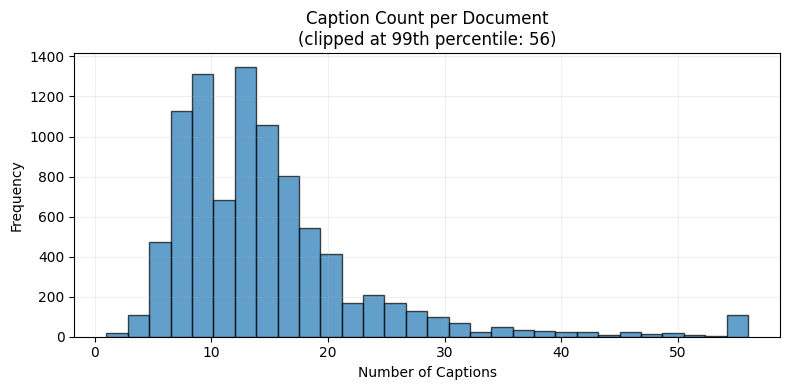

Total documents: 9112
Original mean caption count: 15.14
Clipped mean caption count: 14.71
99th percentile threshold (counts): 56



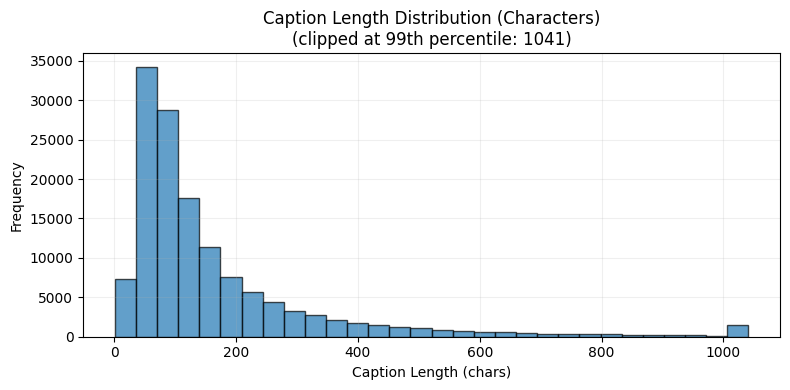

Total captions: 137978
Original mean caption length: 171.06 chars
Clipped mean caption length: 166.01 chars
99th percentile threshold (lengths): 1041 chars
Max original caption length: 13632 chars


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# ---------------------------------------------------
# 1. Load CSV
# ---------------------------------------------------
df = pd.read_csv("./merged_caption_output.csv")

# ---------------------------------------------------
# 2. Parse caption list column safely
# ---------------------------------------------------
def parse(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

cap_lists = df['captions'].apply(parse)

# ---------------------------------------------------
# 3. Caption count per document
# ---------------------------------------------------
counts = cap_lists.apply(len)

# ---------------------------------------------------
# 3-1. Clip top 1% to improve visualization
# ---------------------------------------------------
threshold_counts = np.percentile(counts, 99)
counts_clipped = np.clip(counts, 0, threshold_counts)

# ---------------------------------------------------
# 3-2. Plot clipped histogram
# ---------------------------------------------------
plt.figure(figsize=(8, 4))
plt.hist(counts_clipped, bins=30, edgecolor='black', alpha=0.7)
plt.title(f"Caption Count per Document\n(clipped at 99th percentile: {threshold_counts:.0f})")
plt.xlabel("Number of Captions")
plt.ylabel("Frequency")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print(f"Total documents: {len(df)}")
print(f"Original mean caption count: {np.mean(counts):.2f}")
print(f"Clipped mean caption count: {np.mean(counts_clipped):.2f}")
print(f"99th percentile threshold (counts): {threshold_counts:.0f}")
print()

# ---------------------------------------------------
# 4. Flatten all captions into one list
# ---------------------------------------------------
all_caps = [c for lst in cap_lists for c in lst if isinstance(c, str)]

# ---------------------------------------------------
# 5. Caption length distribution
# ---------------------------------------------------
lengths = [len(c) for c in all_caps]

# ---------------------------------------------------
# 5-1. Clip top 1% for caption lengths
# ---------------------------------------------------
threshold_lengths = np.percentile(lengths, 99)
lengths_clipped = np.clip(lengths, 0, threshold_lengths)

# ---------------------------------------------------
# 5-2. Plot clipped caption length histogram
# ---------------------------------------------------
plt.figure(figsize=(8, 4))
plt.hist(lengths_clipped, bins=30, edgecolor='black', alpha=0.7)
plt.title(f"Caption Length Distribution (Characters)\n(clipped at 99th percentile: {threshold_lengths:.0f})")
plt.xlabel("Caption Length (chars)")
plt.ylabel("Frequency")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print(f"Total captions: {len(all_caps)}")
print(f"Original mean caption length: {np.mean(lengths):.2f} chars")
print(f"Clipped mean caption length: {np.mean(lengths_clipped):.2f} chars")
print(f"99th percentile threshold (lengths): {threshold_lengths:.0f} chars")
print(f"Max original caption length: {np.max(lengths)} chars")
